<a href="https://colab.research.google.com/github/elisasanzani/Software_and_Computing_Project/blob/main/PNet_RMC_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Particle Net Lite Custom DG-CNN**

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import os
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Data is downloaded in one go from Dropbox for simplicity. 
Unzipped version available in [main/data-PNet](https://github.com/elisasanzani/Software_and_Computing_Project/tree/main/data-PNet)

In [3]:
print("\n =========> Fetching input data \n")

#Comment next two lines if data is already available.
!wget https://www.dropbox.com/s/ad08fg4c132nzvo/keras_input.zip?dl=0 -O keras_input.zip
!unzip keras_input.zip

#Folder with input data is the current one. Modify if required.
data_folder = "."


 =========> Fetching input data 

--2022-08-23 06:50:03--  https://www.dropbox.com/s/ad08fg4c132nzvo/keras_input.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ad08fg4c132nzvo/keras_input.zip [following]
--2022-08-23 06:50:03--  https://www.dropbox.com/s/raw/ad08fg4c132nzvo/keras_input.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0f4975d9027a96c33eff41bdf.dl.dropboxusercontent.com/cd/0/inline/BrgnQOvByc7ZHJkdFziWK_X6uwsDjjMS0Tosh1YMTiKqqhU7LlYOXV6p3KSxzJAOl7lJGKjRyAv3SsKxmSms7WO_Z4tz2hogWJBHGO8ar-fhEXqucqqjjXLaMu0bMDVmz1LwjbZCOGuNFaVDnEODkhyUZYxL05s-zEf0ftpOqi9DDg/file# [following]
--2022-08-23 06:50:03--  https://uca0f4975d9027a96c33eff41bdf.dl.dropboxusercontent.com/cd/0/inline/BrgnQOvByc7ZHJkdFzi

The three datasets are saved as dictionaries with 4 components:
<u1 type="circle">
<li>"points": Point Cloud (xy coordinates of each hit of a cluster) - 50 maximum hits </li>
<li>"features": Energy and Time of each hit of a cluster - 50 maximum hits</li>
<li>"mask": Mask to distinguish real hits (filled with 1, the others are filled with 0) in a cluster</li>
<li>"summary": Energy, Time, Centroid Radius, and Number of active cells for a cluster</li>
<br>
The MC data has been filtered with ROOT
using two pre-selection cuts:
E > 50 MeV  &&  R > 480 mm <br>
The cuts are necessary because in the low-energy and low-radius region the 
background due to the beam is too high


In [4]:
name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"}

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

# Data Visualization
Hits on the calorimeter for N = 10 random events per each event type are shown


 =========> Data visualization. [ipython: close the pop-up window when you want to continue] 

 =========> Saving 10 random clusters from signal events



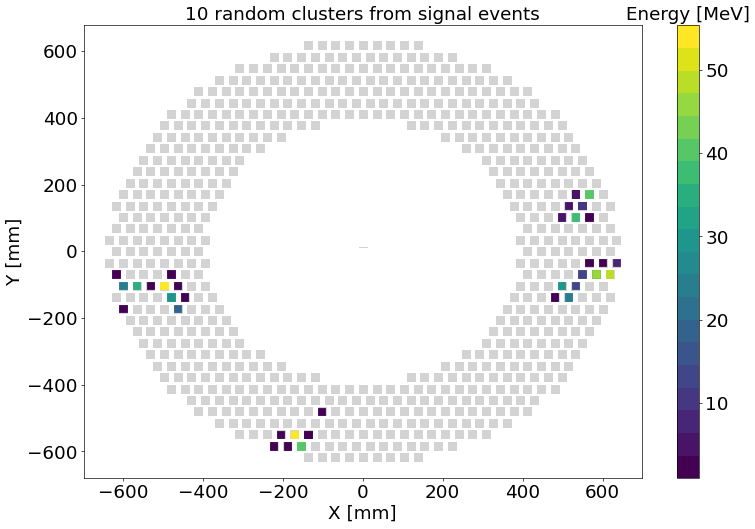

 =========> Saving 10 random clusters from min-bias events



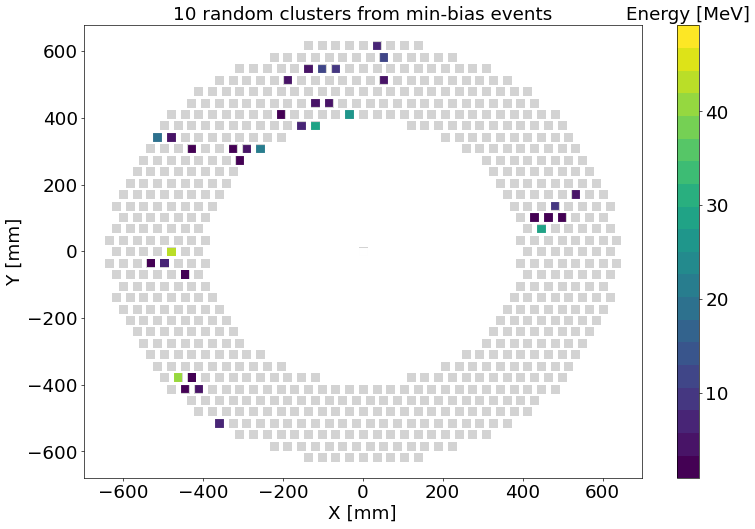

 =========> Saving 10 random clusters from cosmic events



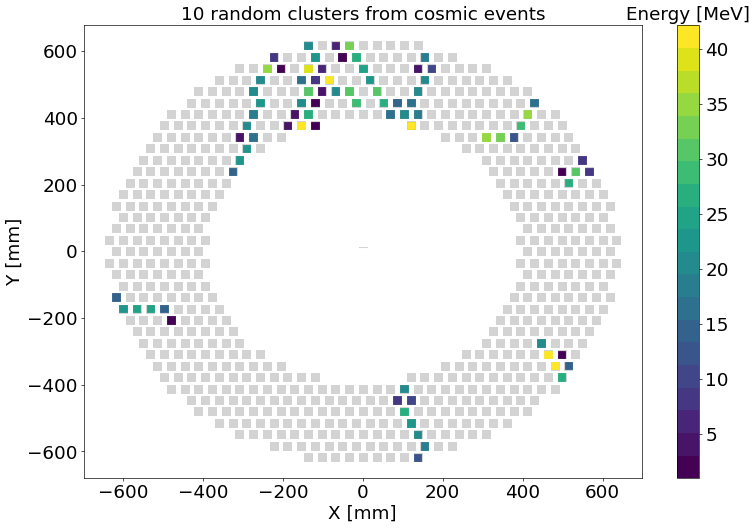

In [10]:
print("\n =========> Data visualization. [ipython: close the pop-up window when you want to continue] \n")

channels = [signal, mnbs, cosmics]
ch_names = ["signal", "min-bias", "cosmic"]

cmap = plt.get_cmap('viridis', 20)
cmap.set_under('white')

N = 10  #Number of events shown

images_dir = './images_PNet'
if not os.path.isdir(images_dir):
    os.makedirs(images_dir)

for ch, name in zip(channels, ch_names):

  evs = np.random.randint(0, high=len(ch["points"]), size=N, dtype=int)
  fig = plt.figure(figsize=(15, 10), dpi=60)
  plt.scatter(cosmics["points"][:, :, 0], cosmics["points"][:, :, 1], marker="s", s=80, color="lightgrey")
  arr_xy = ch["points"][evs]
  x, y = arr_xy[:, :, 0], arr_xy[:, :, 1]
  e = ch["features"][evs][:, :, 0]
  plt.scatter(x, y, c=e, cmap=cmap, vmin=1, marker="s", s=80)
  plt.title(f"{N} random clusters from {name} events", fontsize=22)
  plt.xlabel("X [mm]", fontsize=22)
  plt.ylabel("Y [mm]", fontsize=22)
  plt.xticks(fontsize=22)
  plt.yticks(fontsize=22)
  clb = plt.colorbar()
  clb.ax.set_title('Energy [MeV]',fontsize=22)
  clb.ax.tick_params(labelsize=22)

  plt_name= f"{N}_{name}_events.png"
  filepath_imm = os.path.join(images_dir, plt_name)
  fig.savefig(filepath_imm)
  print(f" =========> Saving {N} random clusters from {name} events\n")
  plt.show() 


# Training
The MC samples are weighted to match the expected ratios in one Mu2e injection cycle. 


Real expected cluster on upstream disk in one injection cycle (1.33s):<br>
RMC: 330 <br>
MNBS: 1.3M <br>
cosmics: 4 <br> <br>

MC cluster on upstream disk:<br>
RMC: 150k<br>
MNBS: 5.25M<br>
cosmics: 53k




In [ ]:
signal_weight = 330/150e3 * 100
mnbs_weight = 1.3/5.25 * 100
cosmics_weight = 4/53e3 * 100

The samples are merged into a unique dataset, which is then shuffled, saving also labels and weights


In [ ]:
S =  signal["mask"].shape[0] 
F =    mnbs["mask"].shape[0] 
C = cosmics["mask"].shape[0]

N = S + F + C

p = np.random.permutation(N) 

In [ ]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"- Entries for signal, mnbs and cosmics:{entries_list}")
print(f"- Weigths for signal, mnbs and cosmics:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]


- Entries for signal, mnbs and cosmics:[41372, 1132, 41598]
- Weigths for signal, mnbs and cosmics:[0.22, 24.761904761904763, 0.007547169811320755]


Data is normalized to help the training

In [ ]:
from sklearn.preprocessing import StandardScaler
import copy
scaler = StandardScaler()

virgin_data = copy.deepcopy(data)

for key in ["points", "features"]:
  data[key][data["mask"].reshape(N, 50)] = scaler.fit_transform(data[key][data["mask"].reshape(N, 50)])

data["summary"] = scaler.fit_transform(data["summary"])

The dataset is divided in training, test and validation with a ratio 7:2:1

In [ ]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

The custom model is imported from the GitHub repo

In [ ]:
print("\n =========> Downloading the custom model from GitHub\n")

!wget https://raw.githubusercontent.com/elisasanzani/Software_and_Computing_Project/main/tf_keras_model.py -O tf_keras_model.py

import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net_lite_custom


 =========> Downloading the custom model from GitHub

--2022-08-15 16:02:22--  https://raw.githubusercontent.com/elisasanzani/Software_and_Computing_Project/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8734 (8.5K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   8.53K  --.-KB/s    in 0s      

2022-08-15 16:02:23 (29.5 MB/s) - ‘tf_keras_model.py’ saved [8734/8734]



In [ ]:
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

model = get_particle_net_lite_custom(input_shapes)

Training parameters

In [ ]:
batch_size = 1024
epochs = 30

Learning Rate <br>
It is exponentially decreased by a factor 0.1 every 10 epochs, for a maximum of 30 epochs.

In [ ]:
def lr_schedule(epoch):
    lr = 1e-2
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

Compilation of the model<br>
All losses and metrics are weighted to match the real statistics<br>
- Loss: Binary Crossentropy <br>
- Metric: Area Under Precision Recall Curve (AUPRC) <br>
- Optimizer: Adam

In [ ]:
print("\n =========> Compiling the model\n")

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              weighted_metrics=[keras.metrics.AUC(curve="PR")],
)
model.summary()


 =========> Compiling the model

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 50, 1)       0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 50, 1)        0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 50, 1)        0           ['tf.cast[0][0]']                
                                                      

*Keras* checkpoints are employed to save the model with the best validation AURPC

In [ ]:
# Prepare model saving directory.
save_dir ='model_checkpoints'
model_name = '%s_model-{val_auc:0.4f}-{epoch:03d}.h5' % "lite"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_auc',
    verbose=1,
    )
progress_bar = keras.callbacks.ProgbarLogger()
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

callbacks = [checkpoint, progress_bar, lr_scheduler]

Model training <br>
Model is trained weighting the data to match the real statistics, by means of the sample_weight attribute (for the training). <br>
Also the validation set is weighted, in order to select the model with the best performances on the real statistics.

In [ ]:
print("\n =========> Starting training\n")

history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"], train_data["summary"]], 
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_data["points"], val_data["features"], val_data["mask"], val_data["summary"]], val_label, val_weight),
    shuffle=True,
    sample_weight=train_weight,
    callbacks=callbacks
)


 =========> Starting training

Epoch 1/30
      0/Unknown - 13s 0s/sample - loss: 0.1477 - auc: 0.7628
Epoch 1: saving model to model_checkpoints/lite_model-0.7808-001.h5
58/58 [==============================] - 16s 280ms/sample - loss: 0.1477 - auc: 0.7628 - val_loss: 0.1549 - val_auc: 0.7808
Epoch 2/30
 0/58 [..............................] - ETA: 0s - loss: 0.0995 - auc: 0.8874
Epoch 2: saving model to model_checkpoints/lite_model-0.8252-002.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0995 - auc: 0.8874 - val_loss: 0.1316 - val_auc: 0.8252
Epoch 3/30
 0/58 [..............................] - ETA: 0s - loss: 0.0854 - auc: 0.9150
Epoch 3: saving model to model_checkpoints/lite_model-0.9297-003.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0854 - auc: 0.9150 - val_loss: 0.0889 - val_auc: 0.9297
Epoch 4/30
 0/58 [..............................] - ETA: 0s - loss: 0.0730 - auc: 0.9382
Epoch 4: saving model to model_checkpoints/lite_model-0

Training history visualization

 =========> Saved loss vs epoch


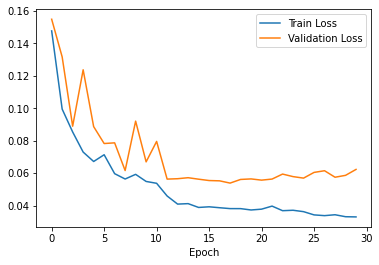

In [ ]:
#Train and validation Loss
fig = plt.figure()
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.legend()
plt_name= "loss_vs_epoch.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm)
print(" =========> Saved loss vs epoch")

 =========> Saved auprc vs epoch


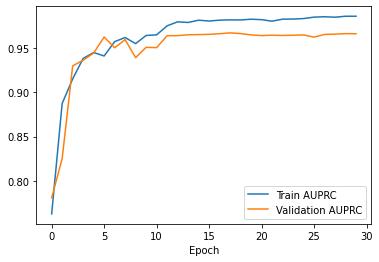

In [ ]:
#Train and validation AUPRC
fig = plt.figure()
plt.plot(history.history['auc'], label="Train AUPRC")
plt.plot(history.history['val_auc'], label="Validation AUPRC")
plt.xlabel("Epoch")
plt.legend()
plt_name= "auprc_vs_epoch.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm)
print(" =========> Saved auprc vs epoch")

The network weights frrom the best model are retreived

In [ ]:
# Select the model with the best val_auc (save_best_only=True in ModelCheckpoint not working)
! ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1
!cp $(ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1) model_checkpoints/last.h5

model_checkpoints/lite_model-0.9710-030.h5


 =========> Best area under precision-recall curve:  0.98640918744123
 =========> Saved best auprc


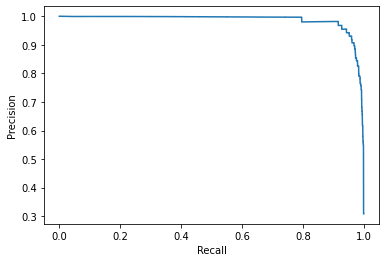

In [ ]:
model.load_weights("model_checkpoints/last.h5")
probs = model.predict_on_batch(test_data)

precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)

fig = plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
print(" =========> Best area under precision-recall curve: ", auc(recall, precision))
plt_name= "best_auprc.png"
filepath_imm = os.path.join(images_dir, plt_name)
plt.savefig(filepath_imm)
print(" =========> Saved best auprc")

In [11]:
print(" =========> Performance plots shown. [ipython: close the pop-up window when you want to continue] \n")
plt.show()

 =========> Performance plots shown. [ipython: close the pop-up window when you want to continue] 



Looking at energy histogram

 =========> Saved energy histogram


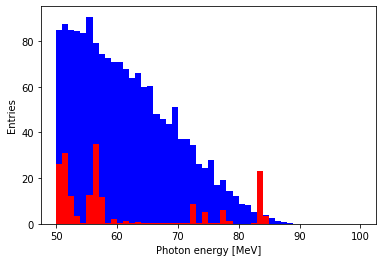

In [ ]:
bin = model.predict(test_data)
bin_sig = bin[test_label == 1][:, 0]
bin_bkg = bin[test_label == 0][:, 0]
weight_sig = test_weight[test_label == 1]
weight_bkg = test_weight[test_label == 0]

test_virgin_data = {key: virgin_data[key][int(N*0.7) : int(N*0.9)] for key in name_map}

en = test_virgin_data["summary"][:, 0]
en_sig = en[test_label == 1]
en_bkg = en[test_label == 0]

fig = plt.figure()
plt.hist(en_sig, range=(50, 100), bins=50, weights=weight_sig * bin_sig, color="blue")
plt.hist(en_bkg, range=(50, 100), bins=50, weights=weight_bkg * bin_bkg, color="red")

plt.xlabel("Photon energy [MeV]")
plt.ylabel("Entries")

plt_name = "energy_histo.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm)
print(" =========> Saved energy histogram")

In [ ]:
#Uncomment to save locally the plots shown in Colab
#If running locally, they are already saved in ./images_PNet

#from google.colab import files
#!zip -r images_PNet.zip images_PNet
#files.download('images_PNet.zip')